In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F

images = np.load("D:/work/JHUschoolStuff/machinelearning/project1/cs475_project_data/images.npy")
labels = np.load("D:/work/JHUschoolStuff/machinelearning/project1/cs475_project_data/labels.npy")
test = np.load("D:/work/JHUschoolStuff/machinelearning/project1/cs475_project_data/test_images.npy")
height = images.shape[1]
width = images.shape[2]
size = height * width
images = (images - images.mean()) / images.std()
data = images.reshape(images.shape[0],size)
test_data = test.reshape(test.shape[0], size)
test_data = (test_data - test_data.mean()) / test_data.std()
batch_size = 1
NUM_OPT_STEPS = 5000
train_seqs = data[0:45000,:]
train_labels = labels[0:45000]
val_seqs = data[45000:,:]
val_labels = labels[45000:]

In [12]:
class_1 = images[labels == 0]
class_2 = images[labels == 1]
class_3 = images[labels == 2]
class_4 = images[labels == 3]
class_5 = images[labels == 4]

print(len(class_1))
print(len(class_2))
print(len(class_3))
print(len(class_4))
print(len(class_5))



10000
10000
10000
10000
10000


Using a random classifier would give you an accuracy of 0.2 because you have a 1/5 chance of getting a prediction correct. A majority vote classifier would get also an accuracy of 0.2 because there are 10000 images of each kind. Therefore we would only get 10000/50000 predictions correct which is 0.2

In [2]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(height * width, 5)
    def forward(self, x):
        x = self.linear(x)
        return x

From the documentation, torch.nn.Linear creates "in features * out features" number of weights and "out features" number of biases(which are booleans). In our case our number of in features is 26*26 = 676 and our number of out features is 5. Therefore the number of weights we have is 676*5 and the number of biases will be 5. This makes sense because our input is a vector of 676 and we have 5 different classes to predict and therefore we would need at least 676*5 weights to compute our prediction, and a bias associated with each prediction.

In [3]:
model = LinearModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

In our previous homeworks we implemented were torch.nn.SGD and torch.nn.Adam, which are the stochastic gradient descent and Adam optimizations. The two most important arguments these optimizers need us to provide are the model parameters themselves and the rate of update. These two allow us to update the weights of our model with a provided rate.

In [4]:
def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_seqs.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int))).long()
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]


In [5]:
def approx_train_accuracy(model):
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    y_hat_ = model(x)
    y_hat = np.zeros(1000)
    for i in range(1000):
        y_hat[i] = torch.max(y_hat_[i,:].data, 0)[1][0]
    return accuracy(y_hat, y.data.numpy())

In [6]:
def val_accuracy(model):
    x = autograd.Variable(torch.from_numpy(val_seqs.astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(val_labels.astype(np.int)))
    y_hat_ = model(x)
    y_hat = np.zeros(5000)
    for i in range(5000):
        y_hat[i] = torch.max(y_hat_[i,:].data, 0)[1][0]
    return accuracy(y_hat, y.data.numpy())

In [7]:
def accuracy(y, y_hat):
    return (y == y_hat).astype(np.float).mean()

In [8]:
def plot(train_accs, val_accs):
    plt.figure(200)
    plt.title('Training Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.plot(train_accs, 'b')
    plt.show()
    plt.figure(300)
    plt.title('Validation Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')   
    plt.plot(val_accs, 'b')
    plt.show()

In [9]:
def runModel(model, batch_size):
    train_accs, val_accs = [], []
    for i in range(NUM_OPT_STEPS):
        train(batch_size)
        if i % 100 == 0:
            train_accs.append(approx_train_accuracy(model))
            val_accs.append(val_accuracy(model))
            print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))
    plot(train_accs, val_accs)

     0  0.17  0.18
   100  0.18  0.18
   200  0.20  0.18
   300  0.19  0.18
   400  0.19  0.18
   500  0.17  0.18
   600  0.19  0.18
   700  0.18  0.18
   800  0.18  0.18
   900  0.21  0.19
  1000  0.21  0.19
  1100  0.20  0.19
  1200  0.20  0.19
  1300  0.19  0.19
  1400  0.18  0.19
  1500  0.21  0.19
  1600  0.21  0.19
  1700  0.20  0.19
  1800  0.21  0.19
  1900  0.20  0.19
  2000  0.19  0.19
  2100  0.19  0.19
  2200  0.21  0.19
  2300  0.20  0.19
  2400  0.19  0.19
  2500  0.20  0.19
  2600  0.19  0.19
  2700  0.18  0.19
  2800  0.20  0.19
  2900  0.20  0.19
  3000  0.20  0.20
  3100  0.21  0.19
  3200  0.20  0.20
  3300  0.22  0.20
  3400  0.20  0.20
  3500  0.19  0.20
  3600  0.19  0.20
  3700  0.20  0.20
  3800  0.20  0.20
  3900  0.21  0.20
  4000  0.20  0.20
  4100  0.23  0.20
  4200  0.22  0.20
  4300  0.20  0.20
  4400  0.21  0.20
  4500  0.22  0.21
  4600  0.19  0.21
  4700  0.21  0.21
  4800  0.20  0.21
  4900  0.21  0.21


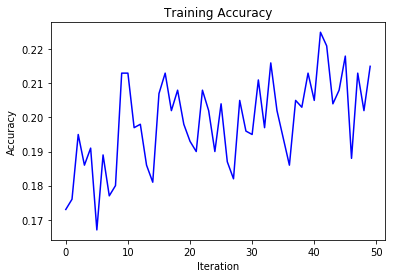

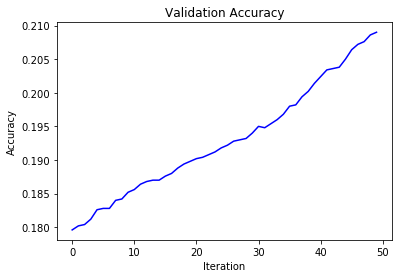

In [10]:
runModel(model, 1)

The top train and validation accuracies we reached were 0.23 for training and 0.21 for validation. The problem here is that we may not have the best hyperparameters for our model. Our learning rate could have been too small which means that our model was not making enough progress toward an optima within our 5k optimization steps.

In [11]:
model = LinearModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

     0  0.24  0.24
   100  0.57  0.61
   200  0.64  0.66
   300  0.65  0.68
   400  0.67  0.69
   500  0.69  0.70
   600  0.70  0.68
   700  0.69  0.70
   800  0.68  0.68
   900  0.67  0.70
  1000  0.73  0.72
  1100  0.69  0.69
  1200  0.71  0.71
  1300  0.72  0.71
  1400  0.70  0.72
  1500  0.72  0.72
  1600  0.71  0.73
  1700  0.68  0.72
  1800  0.71  0.73
  1900  0.74  0.73
  2000  0.70  0.69
  2100  0.71  0.71
  2200  0.70  0.72
  2300  0.68  0.69
  2400  0.69  0.70
  2500  0.70  0.73
  2600  0.73  0.73
  2700  0.71  0.73
  2800  0.69  0.71
  2900  0.69  0.69
  3000  0.69  0.71
  3100  0.70  0.71
  3200  0.72  0.73
  3300  0.70  0.72
  3400  0.70  0.72
  3500  0.74  0.73
  3600  0.70  0.70
  3700  0.70  0.71
  3800  0.70  0.73
  3900  0.73  0.74
  4000  0.70  0.74
  4100  0.69  0.71
  4200  0.70  0.71
  4300  0.70  0.73
  4400  0.71  0.74
  4500  0.69  0.72
  4600  0.73  0.72
  4700  0.70  0.74
  4800  0.73  0.74
  4900  0.75  0.75


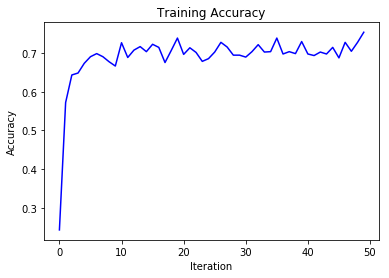

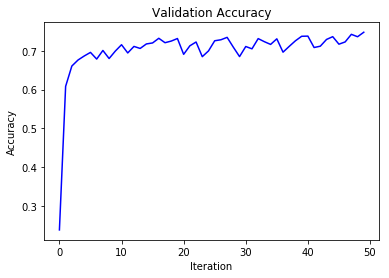

In [12]:
runModel(model, 1)

The final optimizer used was the Adam optimizer with a learning rate of 0.001. This lead to an accuracy in the mid 70s. The best validation accuracy achieved was 76.